In [112]:
import pandas as pd 
from useful_funcs import *

# Getting dfs

In [113]:
gw1_url = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/refs/heads/master/data/2024-25/gws/gw1.csv"
gw1_df = pd.read_csv(gw1_url, index_col=0)

In [114]:
gw_df_list = []
for i in range(1, 39):
    gw_url = f"https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/refs/heads/master/data/2024-25/gws/gw{i}.csv"
    gw_df = pd.read_csv(gw_url, index_col=0)
    gw_df['gw'] = i
    gw_df_list.append(gw_df)

In [115]:
gw_df = pd.concat(gw_df_list)

# Cleaning up dataframe

In [116]:
gw_df.columns

Index(['position', 'team', 'xP', 'assists', 'bonus', 'bps', 'clean_sheets',
       'creativity', 'element', 'expected_assists',
       'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'fixture', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'kickoff_time', 'minutes', 'modified',
       'opponent_team', 'own_goals', 'penalties_missed', 'penalties_saved',
       'red_cards', 'round', 'saves', 'selected', 'starts', 'team_a_score',
       'team_h_score', 'threat', 'total_points', 'transfers_balance',
       'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards',
       'gw', 'mng_clean_sheets', 'mng_draw', 'mng_goals_scored', 'mng_loss',
       'mng_underdog_draw', 'mng_underdog_win', 'mng_win'],
      dtype='object')

In [117]:
gw_df['team_goals'] = gw_df.apply(lambda row: get_team_goals(row['was_home'], row['team_h_score'], row['team_a_score']), axis=1)
gw_df['opponent_goals'] = gw_df.apply(lambda row: get_opponent_goals(row['was_home'], row['team_h_score'], row['team_a_score']), axis=1)
gw_df['team_points'] = gw_df.apply(lambda row: get_team_points(row['was_home'], row['team_h_score'], row['team_a_score']), axis=1)
gw_df['opponent_points'] = gw_df['team_points'].apply(get_opponent_points)

In [118]:
gw_df['full_name'] = [clean_name(idx) for idx in gw_df.index]

In [119]:
gw_df.columns

Index(['position', 'team', 'xP', 'assists', 'bonus', 'bps', 'clean_sheets',
       'creativity', 'element', 'expected_assists',
       'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'fixture', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'kickoff_time', 'minutes', 'modified',
       'opponent_team', 'own_goals', 'penalties_missed', 'penalties_saved',
       'red_cards', 'round', 'saves', 'selected', 'starts', 'team_a_score',
       'team_h_score', 'threat', 'total_points', 'transfers_balance',
       'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards',
       'gw', 'mng_clean_sheets', 'mng_draw', 'mng_goals_scored', 'mng_loss',
       'mng_underdog_draw', 'mng_underdog_win', 'mng_win', 'team_goals',
       'opponent_goals', 'team_points', 'opponent_points', 'full_name'],
      dtype='object')

## New

In [120]:
gw_df.columns

Index(['position', 'team', 'xP', 'assists', 'bonus', 'bps', 'clean_sheets',
       'creativity', 'element', 'expected_assists',
       'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'fixture', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'kickoff_time', 'minutes', 'modified',
       'opponent_team', 'own_goals', 'penalties_missed', 'penalties_saved',
       'red_cards', 'round', 'saves', 'selected', 'starts', 'team_a_score',
       'team_h_score', 'threat', 'total_points', 'transfers_balance',
       'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards',
       'gw', 'mng_clean_sheets', 'mng_draw', 'mng_goals_scored', 'mng_loss',
       'mng_underdog_draw', 'mng_underdog_win', 'mng_win', 'team_goals',
       'opponent_goals', 'team_points', 'opponent_points', 'full_name'],
      dtype='object')

## Finding ewma for player stats

In [121]:
gw_df_players = gw_df[['assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded', 'goals_scored',
                      'influence', 'creativity', 'threat', 'ict_index', 'minutes',
                        'gw', 'full_name', 'total_points', 'position', 'team', 'opponent_team']]

In [122]:
gw_df_players_reset_index = gw_df_players.reset_index()

In [123]:
# Ensure the DataFrame is sorted by 'full_name' and 'gw'
simple_gw_df_reset_index = gw_df_players_reset_index.sort_values(['full_name', 'gw'])

# List of columns to apply EWMA to
# value_cols = ['influence', 'creativity', 'threat', 'ict_index', 'team_goals', 'opponent_goals', 'minutes']
value_cols = ['assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded', 'goals_scored',
                      'influence', 'creativity', 'threat', 'ict_index', 'minutes', 'total_points']

# Apply EWMA within each group
ewma_gw_df_players = (
    simple_gw_df_reset_index
    .groupby('full_name', group_keys=False)
    [value_cols]
    .apply(lambda x: x.ewm(alpha=0.3, adjust=False).mean())
)
ewma_gw_df_players.rename(columns={'total_points': 'ewma_total_points'}, inplace=True)
ewma_gw_df_players = simple_gw_df_reset_index[['full_name', 'gw', 'total_points', 'position','team','opponent_team']].join(ewma_gw_df_players)

## Finding ewma for team stats

In [124]:
gw_df.columns

Index(['position', 'team', 'xP', 'assists', 'bonus', 'bps', 'clean_sheets',
       'creativity', 'element', 'expected_assists',
       'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'fixture', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'kickoff_time', 'minutes', 'modified',
       'opponent_team', 'own_goals', 'penalties_missed', 'penalties_saved',
       'red_cards', 'round', 'saves', 'selected', 'starts', 'team_a_score',
       'team_h_score', 'threat', 'total_points', 'transfers_balance',
       'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards',
       'gw', 'mng_clean_sheets', 'mng_draw', 'mng_goals_scored', 'mng_loss',
       'mng_underdog_draw', 'mng_underdog_win', 'mng_win', 'team_goals',
       'opponent_goals', 'team_points', 'opponent_points', 'full_name'],
      dtype='object')

In [125]:
gw_df_team = gw_df[['team', 'gw', 'team_goals']]



In [126]:
gw_df_team2 = gw_df_team.groupby(['team', 'gw']).first().reset_index()

In [127]:
# Ensure the DataFrame is sorted by 'full_name' and 'gw'
gw_df_team_sorted = gw_df_team2.sort_values(['team', 'gw'])

# List of columns to apply EWMA to
# value_cols = ['influence', 'creativity', 'threat', 'ict_index', 'team_goals', 'opponent_goals', 'minutes']
value_cols = ['team_goals']

# Apply EWMA within each group
ewma_gw_df_team = (
    gw_df_team_sorted
    .groupby('team', group_keys=False)
    [value_cols]
    .apply(lambda x: x.ewm(alpha=0.3, adjust=False).mean())
)

ewma_gw_df_team.rename(columns={'team_goals': 'ewma_team_goals'}, inplace=True)
ewma_gw_df_team = gw_df_team_sorted[['team', 'gw']].join(ewma_gw_df_team)

## Merging team and player ewma

In [128]:
teams_url = 'https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/refs/heads/master/data/2024-25/teams.csv'
teams = pd.read_csv(teams_url)

teamcode_dict = dict(zip(teams['id'], teams['name']))
ewma_gw_df_players['opponent_team_name'] = ewma_gw_df_players['opponent_team'].map(teamcode_dict)

In [129]:
ewma_gw_df_players

,full_name,gw,total_points,position,team,opponent_team,assists,bonus,bps,clean_sheets,goals_conceded,goals_scored,influence,creativity,threat,ict_index,minutes,ewma_total_points,opponent_team_name
17247,aaron_anselmino,25,0,DEF,Chelsea,5,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,Brighton
18040,aaron_anselmino,26,0,DEF,Chelsea,2,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,Aston Villa
18823,aaron_anselmino,27,0,DEF,Chelsea,17,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,Southampton
19611,aaron_anselmino,28,0,DEF,Chelsea,11,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,Leicester
20269,aaron_anselmino,29,0,DEF,Chelsea,1,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,Arsenal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24333,zain_silcott_duberry,34,0,MID,Bournemouth,14,0.0,0.0,0.029660,0.0,0.0,0.0,0.011864,0.005932,0.0,0.001780,0.005932,0.005932,Man Utd
25118,zain_silcott_duberry,35,0,MID,Bournemouth,1,0.0,0.0,0.020762,0.0,0.0,0.0,0.008305,0.004152,0.0,0.001246,0.004152,0.004152,Arsenal
25919,zain_silcott_duberry,36,0,MID,Bournemouth,2,0.0,0.0,0.014533,0.0,0.0,0.0,0.005813,0.002907,0.0,0.000872,0.002907,0.002907,Aston Villa
26720,zain_silcott_duberry,37,0,MID,Bournemouth,13,0.0,0.0,0.010173,0.0,0.0,0.0,0.004069,0.002035,0.0,0.000610,0.002035,0.002035,Man City


In [152]:
ewma_gw_df_opponent_team = ewma_gw_df_team.rename(columns={'team': 'opponent_team_name', 'ewma_team_goals': 'ewma_nw_opponent_goals'})

In [131]:
ewma_gw_df = ewma_gw_df_players.merge(ewma_gw_df_team, on=['team', 'gw'], how='left')
# ewma_gw_df = ewma_gw_df.merge(ewma_gw_df_opponent_team, on=['opponent_team_name', 'gw'], how='left')

In [132]:
ewma_gw_df['nw_total_points'] = (
    ewma_gw_df
    .sort_values(['full_name', 'gw'])
    .groupby('full_name')['total_points']
    .shift(-1)
)

ewma_gw_df['nw_opponent'] = (
    ewma_gw_df
    .sort_values(['full_name', 'gw'])
    .groupby('full_name')['opponent_team_name']
    .shift(-1)
)

In [153]:
ewma_gw_df2 = ewma_gw_df.merge(ewma_gw_df_opponent_team, on=['opponent_team_name', 'gw'], how='left')

# Trying some models

## Random forest

In [164]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [215]:
ewma_gw_df3 = ewma_gw_df2.dropna(subset=['nw_total_points'])
non_zero_players = ewma_gw_df3.groupby('full_name').sum().query('total_points>0').index
ewma_gw_df3 = ewma_gw_df3.query('full_name in @non_zero_players')
ewma_gw_df3 = ewma_gw_df3.query('gw>9')

In [ ]:
ewma_gw_df3_fwd = ewma_gw_df3.query('position=="FWD"').set_index(['full_name', 'gw'])

X = ewma_gw_df3_fwd[[
       'assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded',
       'goals_scored', 'influence', 'creativity', 'threat', 'ict_index',
       'minutes', 'ewma_total_points', 'ewma_team_goals',
       'ewma_nw_opponent_goals']]

y = ewma_gw_df3_fwd['nw_total_points']

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [261]:
model = RandomForestClassifier(random_state=0, n_estimators=300, max_depth=10)
model.fit(X_train, y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [262]:
y_pred = model.predict(X_test)

In [263]:
from sklearn.metrics import accuracy_score

print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with 10 decision-trees : 0.6165


# Lin regress

In [192]:
from sklearn.linear_model import LinearRegression

In [193]:
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [194]:
y_pred = model.predict(X_test)

In [195]:
y_test_df = y_test.to_frame(name='y_test')
y_test_df['y_pred'] = y_pred

<Axes: xlabel='y_test', ylabel='y_pred'>

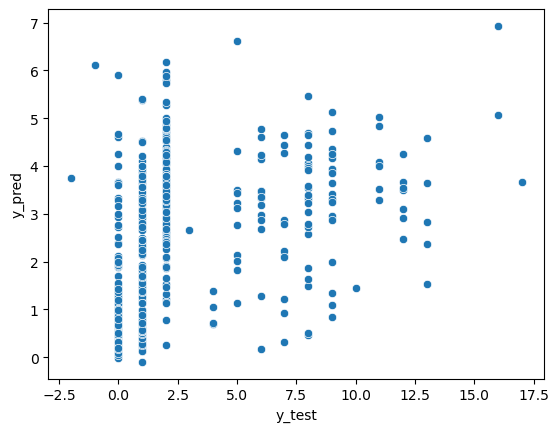

In [196]:
from scipy.stats import linregress

sns.scatterplot(data=y_test_df, x='y_test', y='y_pred')

In [197]:
linregress(y_test_df['y_test'], y_test_df['y_pred'])

LinregressResult(slope=np.float64(0.26550944202204785), intercept=np.float64(1.277215766525023), rvalue=np.float64(0.5170131670192788), pvalue=np.float64(2.6514441513290604e-45), stderr=np.float64(0.017348949113522687), intercept_stderr=np.float64(0.06372210965919131))

## Eval a load of models

In [277]:
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
# from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
for pos in ['FWD', 'MID', 'DEF', 'GK']:
	print(pos)
	ewma_gw_df3_fwd = ewma_gw_df3.query('position==@pos').set_index(['full_name', 'gw'])

	X = ewma_gw_df3_fwd[[
		'assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded',
		'goals_scored', 'influence', 'creativity', 'threat', 'ict_index',
		'minutes', 'ewma_total_points', 'ewma_team_goals',
		'ewma_nw_opponent_goals']]

	y = ewma_gw_df3_fwd['nw_total_points']

	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

	models = []
	models.append(('LR', LinearRegression()))
	models.append(('DT', DecisionTreeClassifier()))
	models.append(('RF', RandomForestClassifier()))
	models.append(('SVR', SVR()))
	models.append(('KNN', KNeighborsRegressor()))
	# models.append(('XGB', XGBRegressor(objective='reg:squarederror')))

	for name, model in models:
		model.fit(X_train, y_train)
		y_pred = model.predict(X_test)
		mse = mean_squared_error(y_test, y_pred)

		print(model)
		print(mse)

FWD
LinearRegression()
7.279451139280787
DecisionTreeClassifier()
11.965863453815262
RandomForestClassifier()
9.052208835341366
SVR()
8.197306837005865
KNeighborsRegressor()
8.49879518072289
MID
LinearRegression()
4.764305587896334
DecisionTreeClassifier()
9.716618635926993
RandomForestClassifier()
5.892891450528338
SVR()
5.446286917930244
KNeighborsRegressor()
5.686954851104707
DEF
LinearRegression()
4.6348379756982245
DecisionTreeClassifier()
8.089930335655477
RandomForestClassifier()
5.794806839772008
SVR()
5.244790070191473
KNeighborsRegressor()
5.662115262824572
GK
LinearRegression()
4.982102492074118
DecisionTreeClassifier()
9.782485875706215
RandomForestClassifier()
6.97457627118644
SVR()
5.6857948596976815
KNeighborsRegressor()
5.7307344632768356


In [287]:
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

for pos in ['FWD', 'MID', 'DEF', 'GK']:
	
    # print(pos)
	# ewma_gw_df3_fwd = ewma_gw_df3.query('position==@pos').set_index(['full_name', 'gw'])

	# X = ewma_gw_df3_fwd[[
	# 	'assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded',
	# 	'goals_scored', 'influence', 'creativity', 'threat', 'ict_index',
	# 	'minutes', 'ewma_total_points', 'ewma_team_goals',
	# 	'ewma_nw_opponent_goals']]

	# y = ewma_gw_df3_fwd['nw_total_points']

	# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

    print(pos)
    ewma_gw_df3_fwd = ewma_gw_df3.query('position==@pos').set_index(['full_name', 'gw'])

    X = ewma_gw_df3_fwd[[
    'assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded',
    'goals_scored', 'influence', 'creativity', 'threat', 'ict_index',
    'minutes', 'ewma_total_points', 'ewma_team_goals',
    'ewma_nw_opponent_goals']]
    y = ewma_gw_df3_fwd['nw_total_points']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

    params = {
            'max_depth': list(range(3,7)),  
        'min_child_weight': list(range(10,51)),
        'learning_rate':  [0.03, 0.15, 0.3, 0.45, 0.6],
        'subsample': stats.uniform(0.8, 0.1),
        'colsample_bytree': [0.8, 0.1]}

    xgb_reg = xgb.XGBRegressor(objective='reg:squarederror')
    xgb_reg.fit(X_train, y_train)

    xgb_cv = RandomizedSearchCV(xgb_reg, params, cv=3, scoring='neg_root_mean_squared_error',
                                random_state=999)

    xgb_cv.fit(X_train, y_train)
    xgb_best = xgb.XGBRegressor(objective='reg:squarederror')
    xgb_best.set_params(**xgb_cv.best_params_)

    xgb_best.fit(X_train, y_train)
    y_pred = xgb_best.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    print(mse)

FWD
7.316965853937466
MID
4.788163923030141
DEF
4.497578664660414
GK
5.265189125526325
